<h1>QC on Cell-level Data: Python</h1>

We want to perform QC at the cell level, and separate cell populations by their transcriptomes. Barcoded data from each experiment can be accessed in the H5 matrix included in the cellranger count output:

<pre>
HMFHVBGX2_cellranger_count_output_Labradoodle_sample1/outs/raw_gene_bc_matrices_h5.h5
</pre>

This code was adapted from examples on the 10x Genomics website:

https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/advanced/h5_matrices

https://s3-us-west-2.amazonaws.com/10x.files/supp/cell-exp/megacell_tutorial.html


In [2]:
# import modules, define some functions for loading, saving and processing a gene-barcode matrix
%matplotlib inline
import re, collections, matplotlib, tables, rpy2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse

np.random.seed(0)

# These are the attributes of the gbc object created by get_matrix_from_h5
GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")
        
def subsample_matrix(gbm, barcode_indices):
    return GeneBCMatrix(gbm.gene_ids, gbm.gene_names, gbm.barcodes[barcode_indices], gbm.matrix[:, barcode_indices])

def get_expression(gbm, gene_name):
    gene_indices = np.where(gbm.gene_names == gene_name.encode())[0] # added conversion to bytes to get this to work
    if len(gene_indices) == 0:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return gbm.matrix[gene_indices[0], :].toarray().squeeze()

### Functions I added

def get_group_expression(gbm, gene_list):
    '''Get 1D array with sum of expr vals across a group of genes in each cell'''
    gene_list = [i.encode() for i in gene_list]
    ind_list = []
    for i in gene_list:
        # 1D array of expression vals for this gene in all cells
        gene_ind = np.where(gbm.gene_names == i)[0]
        #print(gbm.matrix[gene_ind, :].toarray().squeeze())
        #print(gbm.matrix[gene_ind, :].shape)
        ind_list.append(gene_ind[0])
        if len(gene_ind) == 0:
            raise Exception("%s was not found in list of gene names." % i)
    # Sum expression across all genes in gene_list
    all_genes_counts = np.asarray(gbm.matrix[ind_list, :].sum(axis=0)).squeeze() # sum each col across rows
    return(all_genes_counts)

def get_group_expression_allow_miss(gbm, gene_list):
    '''Same as above, but does not throw exception for missing genes'''
    gene_list = [i.encode() for i in gene_list]
    ind_list = []
    for i in gene_list:
        # 1D array of expression vals for this gene in all cells
        gene_ind = np.where(gbm.gene_ids == i)[0]
        #print(gbm.matrix[gene_ind, :].toarray().squeeze())
        #print(gbm.matrix[gene_ind, :].shape)
        if len(gene_ind) == 0:
            pass
        else:
            ind_list.append(gene_ind[0])
    # Sum expression across all genes in gene_list
    all_genes_counts = np.asarray(gbm.matrix[ind_list, :].sum(axis=0)).squeeze() # sum each col across rows
    return(all_genes_counts)

In [3]:
# Make sure to download the H5 matrix into cwd

## Load matrix in gene-barcode matrix (gbm) format: rows = genes, cols = cells
filtered_matrix_h5 = "filtered_gene_bc_matrices_h5.h5"
genome = "canfam3.1"
gene_bc_matrix = get_matrix_from_h5(filtered_matrix_h5, genome)
# print dimensions of matrix
print('Number of cell barcodes:',gene_bc_matrix.barcodes.size)
print('Number of gene barcodes:',gene_bc_matrix.gene_ids.size)

# Note: if you get an error about the genome not existing in this file,
# you can check the genome name by reading in the HDF5 file and printing the top-level data:
#
#with tables.open_file('filtered_gene_bc_matrices_h5.h5','r') as f:
#    for i in f:
#        print(i)

Number of cell barcodes: 1234
Number of gene barcodes: 27980


In [4]:
## Calculate UMIs and genes per cell

umis_per_cell = np.asarray(gene_bc_matrix.matrix.sum(axis=0)).squeeze() # sum each col across rows
genes_per_cell = np.asarray((gene_bc_matrix.matrix > 0).sum(axis=0)).squeeze() # use only rows>0

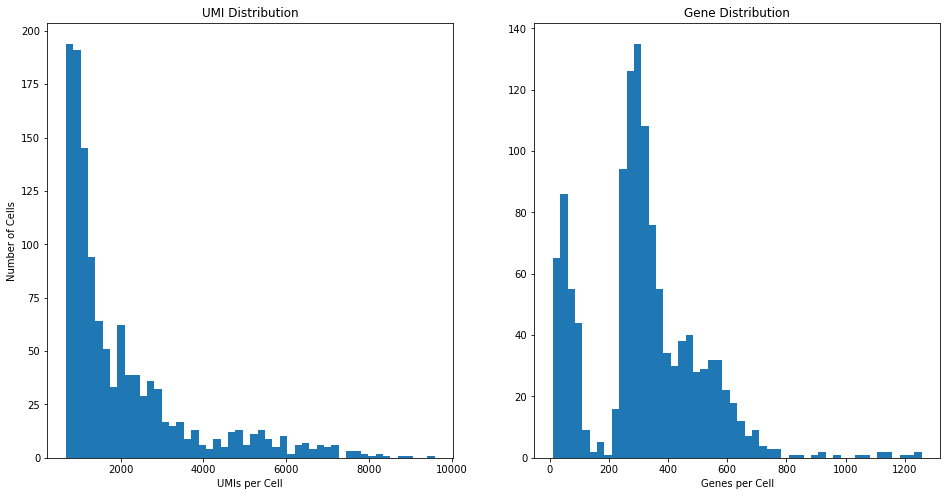

677

In [5]:
## Plot genes, UMIs per cell

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16,8))
ax1.hist(umis_per_cell, bins=50)
ax1.set_title('UMI Distribution')
ax1.set_xlabel('UMIs per Cell')
ax1.set_ylabel('Number of Cells')
ax2.hist(genes_per_cell, bins=50)
ax2.set_xlabel('Genes per Cell')
ax2.set_title('Gene Distribution')
plt.show()

min(umis_per_cell) # [650,4000] UMIs, [200,800] genes seem like sensible ranges for filtering

In [6]:
## Load TSNE and graph clustering data generated by cellranger (found in /outs/analysis)
tsne = pd.read_csv("analysis/tsne/2_components/projection.csv")
clusters = pd.read_csv("analysis/clustering/graphclust/clusters.csv")

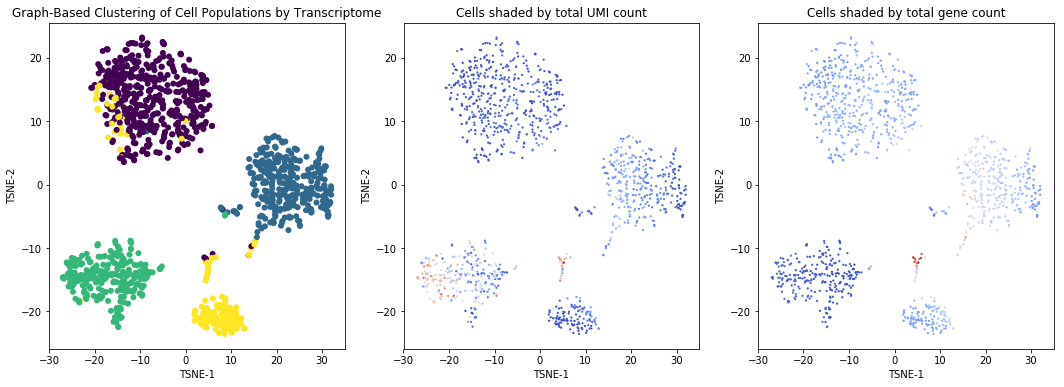

In [7]:
## Plot cell clusters in TSNE space

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(18,6))
ax1.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=clusters['Cluster'], linewidths=0)
ax1.set_title('Graph-Based Clustering of Cell Populations by Transcriptome')
ax1.set_xlabel('TSNE-1')
ax1.set_ylabel('TSNE-2')
ax2.scatter(tsne['TSNE-1'],tsne['TSNE-2'],c=umis_per_cell, s=5,linewidths=0,cmap=plt.cm.coolwarm)
ax2.set_title('Cells shaded by total UMI count')
ax2.set_xlabel('TSNE-1')
ax2.set_ylabel('TSNE-2')
ax3.scatter(tsne['TSNE-1'],tsne['TSNE-2'],c=genes_per_cell, s=5,linewidths=0,cmap=plt.cm.coolwarm)
ax3.set_title('Cells shaded by total gene count')
ax3.set_xlabel('TSNE-1')
ax3.set_ylabel('TSNE-2')
plt.show()

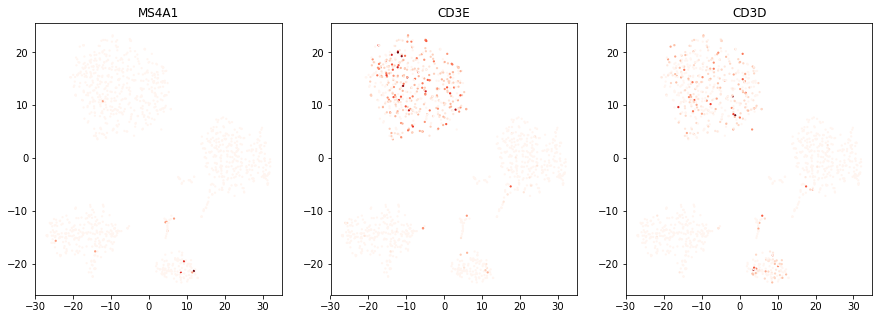

In [11]:
## Plot expression levels of cell type markers: https://www.bio-rad-antibodies.com/dog-canine-cd-marker-antibodies.html

# ENSCAFG00000011630 = CD21 homolog (B cell),
# MS4A1 = CD20 homolog (B cell marker)
# CD8A, CD8B = CD8 homologs (T cell marker)
# CD3, CD5 = other T cell markers

marker_genes = ['MS4A1','CD3E','CD3D'] # only showing those with strong signal
f, axes = plt.subplots(1, len(marker_genes), figsize=(5*len(marker_genes), 5))
for gene, axis in zip(marker_genes, axes):
    expr = get_expression(gene_bc_matrix, gene)
    axis.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()


Max % expr of MT genes 0.0379746835443


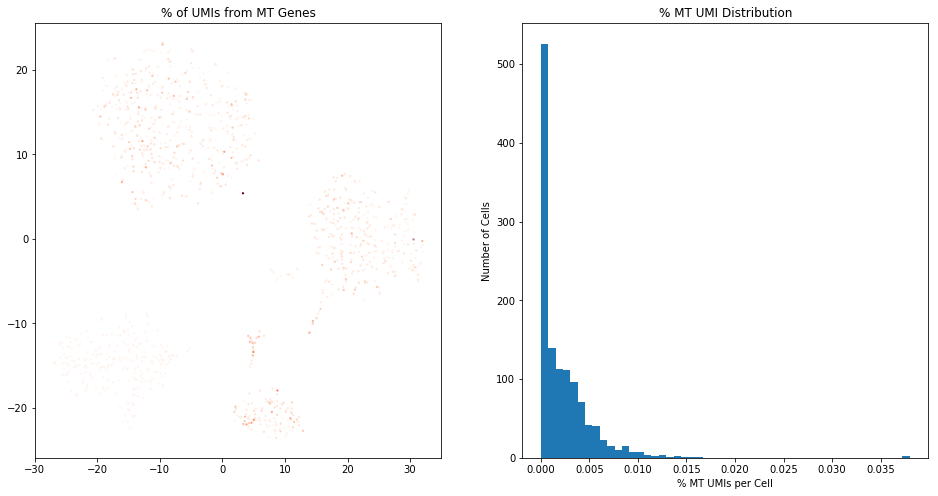

In [12]:
## Plot expression of MT genes by cell in TSNE space

MT_rgx = re.compile('\t(MT-[\w]{1,})\n')
gene_name_list = open('./canfam3.1/genes.tsv','r').read()
MT_genes = re.findall(MT_rgx, gene_name_list)

# % UMIs per cell coming from any MT genes
total_p_MT = get_group_expression(gene_bc_matrix,MT_genes)/umis_per_cell
print('Max % expr of MT genes',max(total_p_MT))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16,8))
ax1.scatter(tsne['TSNE-1'],tsne['TSNE-2'],c=total_p_MT, s=5,linewidths=0,cmap=plt.cm.Reds)
ax1.set_title('% of UMIs from MT Genes')
ax2.hist(total_p_MT, bins=50)
ax2.set_title('% MT UMI Distribution')
ax2.set_xlabel('% MT UMIs per Cell')
ax2.set_ylabel('Number of Cells')
plt.show()


1400 dog X genes
Max % expr of X genes 0.184415584416


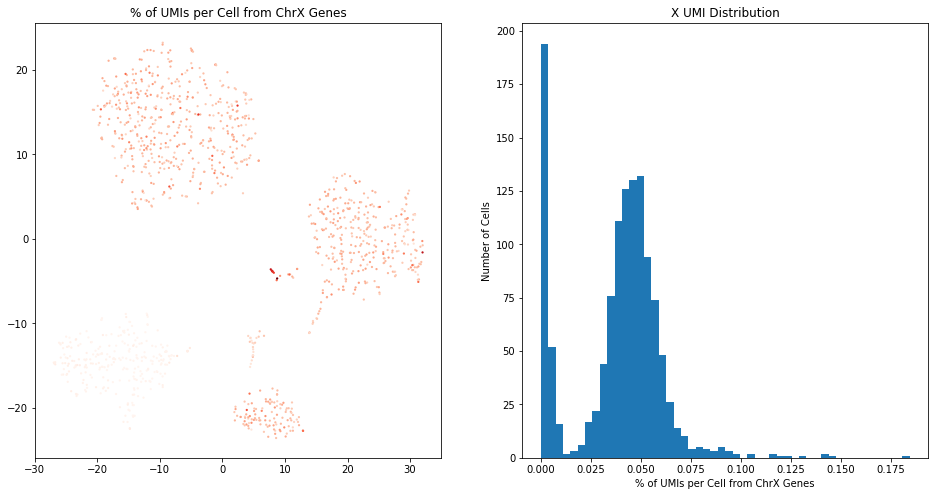

In [13]:
# Make sure expression of X genes isn't mostly coming from one cell pop

dog_X_ENSG = open('/Users/andreaslavney/Desktop/new_5-12-17/Dog_DogRef.txt','r').read().split('\n')
del(dog_X_ENSG[0]) # remove header
print(len(dog_X_ENSG), 'dog X genes')

X_genes = dog_X_ENSG
total_p_X = get_group_expression_allow_miss(gene_bc_matrix,X_genes)/umis_per_cell
print('Max % expr of X genes',max(total_p_X))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16,8))
ax1.scatter(tsne['TSNE-1'],tsne['TSNE-2'],c=total_p_X, s=5,linewidths=0,cmap=plt.cm.Reds)
ax1.set_title('% of UMIs per Cell from ChrX Genes')
ax2.hist(total_p_X, bins=50)
ax2.set_title('X UMI Distribution')
ax2.set_xlabel('% of UMIs per Cell from ChrX Genes')
ax2.set_ylabel('Number of Cells')
plt.show()